# Find the fingerprints of ENSO and the IPO in observed gridded datasets

Purpose
-------

    1.    Decompose the temperature time series into Intrinsic Mode Functions (IMFs) using EMD.
            i)  remove monthly climatology
            ii) remove linear trend over timeseries
    2.    Identify and correlate relevant IMFs with known indices for ENSO and IPO.
    3.    Compute slope of relationship between ENSO/IPO and variable of interest to quantify effect of ENSO/IPO


### IMPORTS

In [2]:

import sys
import os
import glob

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import cmocean.cm as cmo
from cmocean.tools import lighten
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# oceanographic
import gsw as gsw

# statistics
import scipy as sci
from scipy.signal import hilbert
from PyEMD import EMD

# regridding package
import xesmf as xe

# Copernicus marine toolbox
#import copernicusmarine
#from pprint import pprint
#copernicusmarine.login()

# print versions of packages
print("python version =",sys.version[:5])
print("numpy version =", np.__version__)
print("pandas version =", pd.__version__)
print("scipy version =", sci.__version__)
print("xarray version =", xr.__version__)
print("xesmf version =", xe.__version__)
print("cartopy version =", sys.modules[ccrs.__package__].__version__)
print("matplotlib version =", sys.modules[plt.__package__].__version__)
print("cmocean version =", sys.modules[cmo.__package__].__version__)


wrkdir="/g/data/es60/pjb581/SPC"
os.chdir(wrkdir)
os.getcwd()


python version = 3.10.
numpy version = 2.1.3
pandas version = 2.2.3
scipy version = 1.15.1
xarray version = 2024.11.0
xesmf version = 0.8.8
cartopy version = 0.24.0
matplotlib version = 3.10.0
cmocean version = v3.0.3


'/g/data/es60/pjb581/SPC'

### LOAD DATA

In [3]:
%%time

datapath = "/g/data/es60/observations/OCNET_Hong2023"

# 1. Use glob to get all matching files
files = glob.glob(datapath + "/OCNET_chla_*.nc")

# 2. Pass the list to open_mfdataset
all_ds = xr.open_mfdataset(files, combine='by_coords').squeeze()
all_ds



CPU times: user 330 ms, sys: 314 ms, total: 644 ms
Wall time: 3.52 s


<xarray.Dataset> Size: 209GB
Dimensions:    (time: 8400, Columns: 1440, Rows: 721, Longitude: 1440,
                Latitude: 721)
Coordinates:
  * time       (time) datetime64[ns] 67kB 2001-01-02 2001-01-03 ... 2024-01-01
Dimensions without coordinates: Columns, Rows, Longitude, Latitude
Data variables:
    longitude  (time, Columns, Rows) float64 70GB dask.array<chunksize=(365, 1440, 721), meta=np.ndarray>
    latitude   (time, Columns, Rows) float64 70GB dask.array<chunksize=(365, 1440, 721), meta=np.ndarray>
    Chla       (time, Longitude, Latitude) float64 70GB dask.array<chunksize=(365, 1440, 721), meta=np.ndarray>

## take monthly means of the Chl-a

In [4]:
%%time

monthly_ds = all_ds.resample(time='ME').mean()


CPU times: user 2.4 s, sys: 48.2 ms, total: 2.45 s
Wall time: 2.45 s


## Remove the Rows and Columns dimensions

In [5]:
%%time

chl = xr.DataArray(
    monthly_ds['Chla'].sel(time=slice("2001-01-01","2023-12-31")).values,
    coords={
        "time": monthly_ds.coords['time'].sel(time=slice("2001-01-01","2023-12-31")).values,
        "longitude": monthly_ds['longitude'].isel(time=0, Rows=0).values,
        "latitude": monthly_ds['latitude'].isel(time=0, Columns=0).values,
    },
    dims=['time', 'longitude', 'latitude'],
    name='chlorophyll-a'
)

chl = chl.transpose("time", "latitude", "longitude")
chl


CPU times: user 3min 17s, sys: 2min 8s, total: 5min 25s
Wall time: 2min 46s


<xarray.DataArray 'chlorophyll-a' (time: 276, latitude: 721, longitude: 1440)> Size: 2GB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time       (time) datetime64[ns] 2kB 2001-01-31 2001-02-28 ... 2023-12-31
  * longitude  (longitude) float64 12kB -179.9 -179.6 -179.4 ... 179.6 179.9
  * latitude   (latitude) float64 6kB 90.12 89.88 89.62 ... -89.38 -89.62 -89.88

## roll the longitude coordinate

In [6]:
chla = chl.roll(longitude=720, roll_coords=True)
print(chla.coords['longitude'])

lons = chla.coords['longitude'].values
lons[lons<0.0] += 360.0

chla = chla.assign_coords({"longitude":lons})


<xarray.DataArray 'longitude' (longitude: 1440)> Size: 12kB
array([ 0.125,  0.375,  0.625, ..., -0.625, -0.375, -0.125])
Coordinates:
  * longitude  (longitude) float64 12kB 0.125 0.375 0.625 ... -0.375 -0.125


## Save the array for later

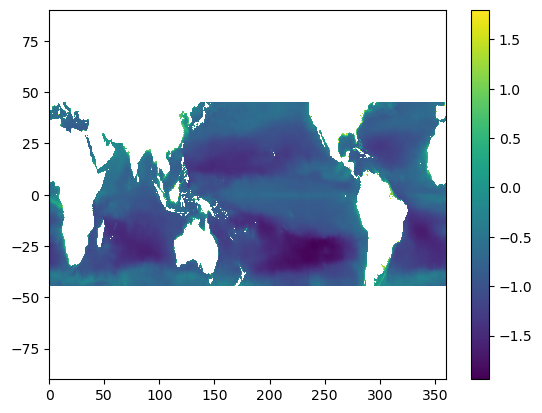

In [7]:
plt.figure()
plt.pcolormesh(chla.coords['longitude'], chla.coords['latitude'], np.log10(chla.isel(time=0)))
plt.colorbar()


In [8]:
os.chdir(wrkdir + "/data")

#os.remove("OCNET_chla_2001-2023.nc")

chla.to_netcdf("OCNET_chla_2001-2023.nc")


## remove the monthly climatology from the Chl-a

CPU times: user 2.76 s, sys: 2.23 s, total: 4.99 s
Wall time: 4.99 s


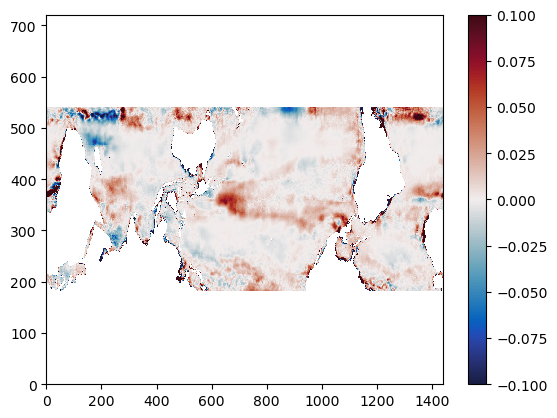

In [38]:
%%time

chla_clim = chla.groupby('time.month').mean('time')
chla_anom = chla.groupby('time.month') - chla_clim

plt.figure()
plt.pcolormesh(chla_anom.isel(time=0), cmap=cmo.balance, vmin=-0.1, vmax=0.1)
plt.colorbar()


In [39]:
%%time

### remove global trend
def detrend_1d(arr):
    """Remove the linear trend from a 1D array."""
    x = np.arange(len(arr))
    # Fit a linear trend
    coeffs = np.polyfit(x, arr, 1)
    trend = np.polyval(coeffs, x)
    # Remove the trend
    detrended = arr - trend
    return detrended

chla_detr = xr.apply_ufunc(
    detrend_1d,
    chla_anom,
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[chla_anom.dtype]
)

chla_detr


CPU times: user 1min 48s, sys: 613 ms, total: 1min 48s
Wall time: 1min 48s


<xarray.DataArray 'chlorophyll-a' (latitude: 721, longitude: 1440, time: 276)> Size: 2GB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time       (time) datetime64[ns] 2kB 2001-01-31 2001-02-28 ... 2023-12-31
  * latitude   (latitude) float64 6kB 90.12 89.88 89.62 ... -89.38 -89.62 -89.88
  * longitude  (longitude) float64 12kB 0.125 0.375 0.625 ... 359.4 359.6 359.9
    month      (time) int64 2kB 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12

CPU times: user 4.92 s, sys: 581 ms, total: 5.5 s
Wall time: 5.51 s


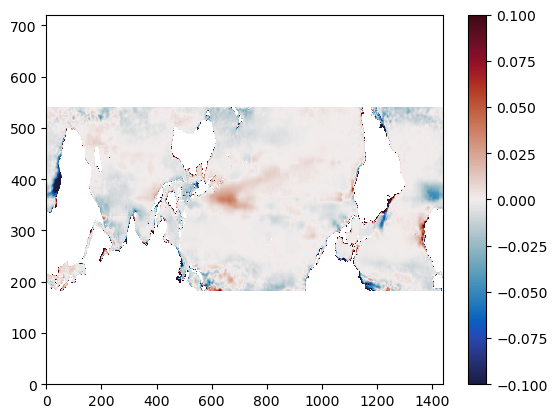

In [41]:
%%time

### retrive the linear least squares trend
chla_trend = chla_anom - chla_detr

### since the trends are linear, they can be described by one number (their slope)
### calculate the slope on a decadal timescale
dates = chla_anom.coords['time']
chla_trend = chla_trend.sel(time=dates[-1]) - chla_trend.sel(time=dates[0]) / len(dates) * 12 * 10

plt.figure()
plt.pcolormesh(chla_trend, cmap=cmo.balance, vmin=-0.1, vmax=0.1)
plt.colorbar()


## Undertake the decomposition at each grid cell across the ocean

In [42]:
np.shape(chla_anom)

(276, 721, 1440)

In [43]:
%%time

import signal
emd = EMD()

years = np.arange(2001+0.5/12, 2023+11.51/12, 1/12)
times = chla_anom.coords['time'].values
lats = chla_anom.coords['latitude'].values
lons = chla_anom.coords['longitude'].values
chla_imfs = np.zeros((3,len(times),len(lats),len(lons)))


## Define a timeout handler
#def timeout_handler(signum, frame):
#    raise TimeoutError

## Register the timeout handler for the alarm signal
#signal.signal(signal.SIGALRM, timeout_handler)

def find_imf_freq(imfs):
    inst_freqs = []
    for imf in imfs:
        analytic_signal = hilbert(imf)
        amplitude_envelope = np.abs(analytic_signal)
        instantaneous_phase = np.unwrap(np.angle(analytic_signal))
        instantaneous_frequency = np.diff(instantaneous_phase) / (2.0 * np.pi * np.diff(years))
        inst_freqs.append(instantaneous_frequency)
    return np.array([np.mean(freq) for freq in inst_freqs])
    

def set_imfs(imfs, freqs):
    # add IMFs to the master array and merge IMFs into sub-annual, inter-annual, decadal and trend
    lentmp = np.shape(imfs)[0]
    if lentmp > 0:
        mask1 = freqs > 1                       # oscillates with period less than 1 year
        mask2 = (freqs < 1) & (freqs > 0.2)     # oscillates with period between 1 and 5 years
        mask3 = (freqs < 0.2) & (freqs > 0.0)   # oscillates with period greater than 5 years
        out1 = np.mean(imfs[mask1],axis=0)
        out2 = np.mean(imfs[mask2],axis=0)
        out3 = np.mean(imfs[mask3],axis=0)
    else:
        out1 = np.zeros(len(sstimfs[0,:]))
        out2 = np.zeros(len(sstimfs[0,:]))
        out3 = np.zeros(len(sstimfs[0,:]))
    return np.array([out1, out2, out3])



CPU times: user 575 μs, sys: 128 μs, total: 703 μs
Wall time: 689 μs


In [44]:
%%time

for ix,lon in enumerate(lons):
    if ix % 20 == 0:
        print(ix)
    for iy,lat in enumerate(lats):
        #signal.alarm(10)
        
        # decompose
        if np.any(np.isnan(chla_detr.isel(longitude=ix, latitude=iy).values)):
            continue
        else:
            chlaimfs = emd(chla_detr.isel(longitude=ix, latitude=iy).values, max_imf=5)
            #try:
            #    chlimfs = emd(chl_detr.isel(longitude=ix, latitude=iy).values, max_imf=5)
            #except TimeoutError:
            #    print("timed out at x=%i and y=%i"%(ix,iy))
            
        # check that the IMFs are actually valid and not spurious
        #sumrow = np.abs(np.sum(imfs, axis=1))
        #mask = sumrow >= 1e-2
        #imfs = imfs[mask]
        
        # determine the frequencies of the IMFs
        chla_freqs = find_imf_freq(chlaimfs)
        
        # add IMFs to the master array and merge IMFs into sub-annual, inter-annual, decadal and trend
        chla_imfs[:,:,iy,ix] = set_imfs(chlaimfs, chla_freqs)


0
20
40


/g/data/es60/pjb581/miniforge3/envs/pyEMD_env/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/g/data/es60/pjb581/miniforge3/envs/pyEMD_env/lib/python3.10/site-packages/numpy/_core/_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
1000
1020
1040
1060
1080
1100
1120
1140
1160
1180
1200
1220
1240
1260
1280
1300
1320
1340
1360
1380
1400
1420
CPU times: user 2h 1min 53s, sys: 20.9 s, total: 2h 2min 13s
Wall time: 2h 2min 16s


In [45]:
# Create xarray Datasets
imfs_ds = xr.Dataset(
    {
        "chl_imfs": (["IMF", "time", "lat", "lon"], chla_imfs),
        "chl_anom": (["time", "lat", "lon"], chla_anom.values),
        "chl_detr": (["time", "lat", "lon"], chla_detr.transpose("time", "latitude", "longitude").values),
        "chl_trend": (["lat", "lon"], chla_trend.values),
    },
    coords={
        "IMF": np.arange(1,4,1),
        "time": dates,
        "lat": lats,
        "lon": lons,
    },
)

os.chdir(wrkdir + "/data/")

os.remove("imfs_chl.nc")

imfs_ds.to_netcdf("imfs_chl.nc")


In [46]:
imfs_ds

<xarray.Dataset> Size: 11GB
Dimensions:    (IMF: 3, time: 276, lat: 721, lon: 1440)
Coordinates:
  * time       (time) datetime64[ns] 2kB 2001-01-31 2001-02-28 ... 2023-12-31
    month      (time) int64 2kB 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12
  * IMF        (IMF) int64 24B 1 2 3
  * lat        (lat) float64 6kB 90.12 89.88 89.62 ... -89.38 -89.62 -89.88
  * lon        (lon) float64 12kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
Data variables:
    chl_imfs   (IMF, time, lat, lon) float64 7GB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    chl_anom   (time, lat, lon) float64 2GB nan nan nan nan ... nan nan nan nan
    chl_detr   (time, lat, lon) float64 2GB nan nan nan nan ... nan nan nan nan
    chl_trend  (lat, lon) float64 8MB nan nan nan nan nan ... nan nan nan nan